In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from glob import glob
import cv2

import albumentations as A
from albumentations import ImageOnlyTransform

# ============================================================
# 📁 PATHS
# ============================================================
BASE_DIR = "/data/ephemeral/home/data"
RAW_TRAIN_DIR = os.path.join(BASE_DIR, "raw", "train")
TRAIN_CSV = os.path.join(BASE_DIR, "raw", "train.csv")

OUT_DIR = os.path.join(BASE_DIR, "processed", "stage0_10_0_train_v10")
META_OUT = os.path.join(BASE_DIR, "meta_stage0_10_0_train_v10.csv")
os.makedirs(OUT_DIR, exist_ok=True)

# ============================================================
# 🧾 데이터 로드 & 잘못된 라벨 수정 
# ============================================================
train_df = pd.read_csv(TRAIN_CSV)

# index 기반 라벨 수정
fix_map = {
    428: 7,
    1095: 14,
    862: 3,
    192: 7,
    1237: 14,
    38: 10,
    340: 10,
}
for idx, val in fix_map.items():
    if idx < len(train_df):
        train_df.loc[idx, "target"] = val

print("✅ Label 수정 완료:", len(fix_map), "개 적용")

# ============================================================
# 🧩 Fake Pattern Generator 정의 (PatternGenerator 대체)
# ============================================================
class FakePatternGenerator:
    def __init__(self, imgx=120, imgy=120, color=(130, 130, 130), alpha=0.15):
        self.imgx = imgx
        self.imgy = imgy
        self.color = color
        self.alpha = alpha

    def __call__(self, image):
        h, w = image.shape[:2]
        noise = np.random.normal(0, 25, (h, w, 3)).astype(np.uint8)
        noise = cv2.cvtColor(noise, cv2.COLOR_BGR2RGB)
        pattern = cv2.GaussianBlur(noise, (self.imgx // 10 * 2 + 1, self.imgy // 10 * 2 + 1), 0)
        blended = cv2.addWeighted(image, 1 - self.alpha, pattern, self.alpha, 0)
        return blended

class PatternGeneratorTransform(ImageOnlyTransform):
    def __init__(self, pattern_generator=None, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.pattern_generator = pattern_generator or FakePatternGenerator()

    def apply(self, img, **params):
        return self.pattern_generator(img)

# ============================================================
# 📦 Albumentations 증강 세트 정의
# ============================================================
horizontal_flip = A.Compose([A.HorizontalFlip(p=1)])
vertical_flip = A.Compose([A.VerticalFlip(p=1)])
double_flip = A.Compose([A.HorizontalFlip(p=1), A.VerticalFlip(p=1)])
transpose = A.Compose([A.Transpose(p=1)])
transpose_hflip = A.Compose([A.Transpose(p=1), A.HorizontalFlip(p=1)])
transpose_vflip = A.Compose([A.Transpose(p=1), A.VerticalFlip(p=1)])
transpose_dflip = A.Compose([A.Transpose(p=1), A.HorizontalFlip(p=1), A.VerticalFlip(p=1)])

base_aug_types = [
    ("hf_", horizontal_flip),
    ("vf_", vertical_flip),
    ("df_", double_flip),
    ("t_", transpose),
    ("thf_", transpose_hflip),
    ("tvf_", transpose_vflip),
    ("tdf_", transpose_dflip)
]

pattern = FakePatternGenerator(
    imgx=120,
    imgy=120,
    color=(130, 130, 130),
    alpha=0.15
)

noise_rotate = A.Compose([
    A.OneOf([
        A.GaussNoise(var_limit=(100, 900), per_channel=False, p=1),
        PatternGeneratorTransform(pattern, p=1),
    ], p=0.8),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.2),
        A.Blur(blur_limit=(2, 4), p=1),
    ], p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(p=0.2),
    A.ToGray(p=0.3),
    A.ShiftScaleRotate(
        shift_limit=0.2,
        scale_limit=0,
        rotate_limit=30,
        p=0.5,
        border_mode=0,
        value=(255, 255, 255)
    ),
])

# ============================================================
# 🚀 증강 루프 (raw → stage0_10_0)
# ============================================================
records = []

print("🧩 Base flip/transpose 증강 시작...")
for i, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img_name = str(row["ID"]) if "ID" in row else str(row[0])
    tgt = int(row["target"])
    img_path = os.path.join(RAW_TRAIN_DIR, img_name)
    if not os.path.exists(img_path):
        continue

    try:
        img = np.array(Image.open(img_path).convert("RGB"))
    except:
        continue

    # 원본 저장
    save_path = os.path.join(OUT_DIR, img_name)
    if not os.path.exists(save_path):
        Image.fromarray(img).save(save_path)
    records.append((save_path, img_name, tgt))

    # 플립/전치 증강
    for prefix, aug_fn in base_aug_types:
        aug_img = aug_fn(image=img)["image"]
        new_name = prefix + img_name
        new_path = os.path.join(OUT_DIR, new_name)
        Image.fromarray(aug_img).save(new_path)
        records.append((new_path, new_name, tgt))

# Heavy noise 증강
print("💣 Noise+Rotate 증강 시작...")
snapshot = list(records)
for (img_path, img_name, tgt) in tqdm(snapshot, desc="NoiseRotate"):
    try:
        img = np.array(Image.open(img_path).convert("RGB"))
    except:
        continue
    for i in range(7):
        aug_img = noise_rotate(image=img)["image"]
        new_name = f"nr{i}_{img_name}"
        new_path = os.path.join(OUT_DIR, new_name)
        Image.fromarray(aug_img).save(new_path)
        records.append((new_path, new_name, tgt))

# ============================================================
# 🧾 메타 저장
# ============================================================
meta = pd.DataFrame(records, columns=["filepath", "ID", "target"])
meta.to_csv(META_OUT, index=False)

print(f"\n✅ 완료: 총 {len(meta)}장 저장")
print(f"📁 경로: {OUT_DIR}")
print(f"📄 메타: {META_OUT}")


/tmp/ipykernel_338157/1739553067.py:100: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(100, 900), per_channel=False, p=1),
/data/ephemeral/home/py310/lib/python3.10/site-packages/albumentations/augmentations/blur/functional.py:231: UserWarning: blur_limit: Invalid kernel size range (2, 4). Values less than 3 are not allowed. Range automatically adjusted to (3, 4).
  result = _ensure_min_value(result, min_value, info.field_name)
/data/ephemeral/home/py310/lib/python3.10/site-packages/albumentations/augmentations/blur/functional.py:232: UserWarning: blur_limit: Non-zero kernel sizes must be odd. Range (3, 4) automatically adjusted to (3, 5).
  result = _ensure_odd_values(result, info.field_name)
/data/ephemeral/home/py310/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs

✅ Label 수정 완료: 7 개 적용
🧩 Base flip/transpose 증강 시작...


100%|███████████████████████████| 1570/1570 [00:24<00:00, 63.55it/s]


💣 Noise+Rotate 증강 시작...


NoiseRotate: 100%|████████████| 12560/12560 [12:37<00:00, 16.59it/s]



✅ 완료: 총 100480장 저장
📁 경로: /data/ephemeral/home/data/processed/stage0_10_0_train_v10
📄 메타: /data/ephemeral/home/data/meta_stage0_10_0_train_v10.csv


📂 총 100480장 중 일부 확인


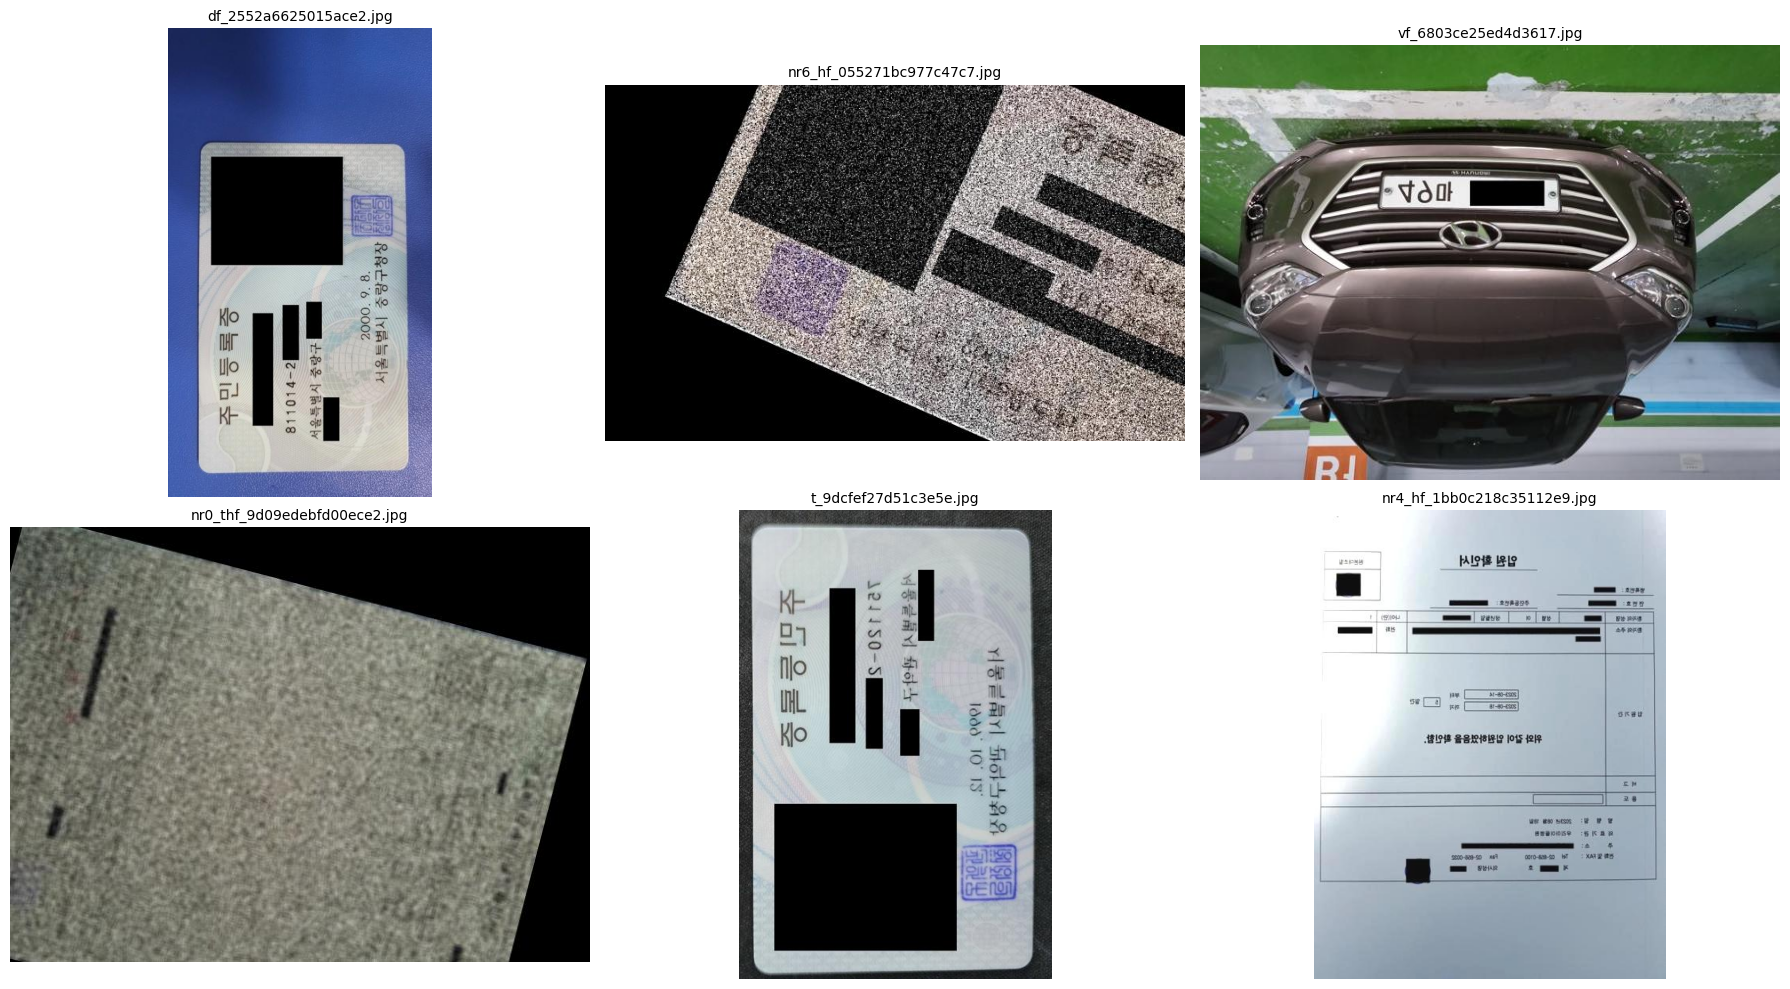

In [4]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# 경로 설정
OUT_DIR = "/data/ephemeral/home/data/processed/stage0_10_0_train_v10"

# 저장된 이미지 리스트 불러오기
all_images = [f for f in os.listdir(OUT_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
print(f"📂 총 {len(all_images)}장 중 일부 확인")

# 무작위 6개 추출
sample_images = random.sample(all_images, 6)

# 이미지 표시
plt.figure(figsize=(18, 10))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(OUT_DIR, img_name)
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(img_name, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
